In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, recall_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import sqlite3
import pandas as pd

In [2]:
conn = sqlite3.connect(r'C:\Users\spiri\codingbootcamp\Final-project-C4Y\data.db')
cursor = conn.cursor()

In [45]:
query = ('''
WITH mean_deposite as (
    select client_id, AVG(balance) as mean_balance, MAX(balance) as max_balance, MIN(balance) as min_balance, currency
    from balances
    group by 1
)
Select * 
from inv_campaign_eval
left join client
on inv_campaign_eval.client_id = client.client_id
left join client_products
on inv_campaign_eval.client_id = client_products.client_id
left join mean_deposite
on inv_campaign_eval.client_id = mean_deposite.client_id''')
df = pd.read_sql_query(query, conn)

df.head()

,client_id,poutcome,client_id,age,job,marital,education,gender,client_id,has_deposits,loan,has_insurance,has_mortgage,client_id,mean_balance,max_balance,min_balance,currency
0,249789938,success,249789938,38.0,services,married,secondary,M,249789938,yes,no,n,no,249789938,2669.532734,2775.615374,2515.500059,CZK
1,1504633819,failure,1504633819,38.0,management,married,tertiary,M,1504633819,no,yes,n,yes,1504633819,5440.862334,5529.866975,5344.385346,CZK
2,1952195738,success,1952195738,34.0,services,married,secondary,M,1952195738,yes,yes,n,no,1952195738,2922.958852,3016.314818,2852.824056,CZK
3,989726384,success,989726384,62.0,retired,married,secondary,F,989726384,yes,no,n,no,989726384,3124.614843,3212.174671,3011.445910,CZK
4,1971878545,failure,1971878545,36.0,management,single,tertiary,M,1971878545,yes,no,n,no,1971878545,474.083033,571.028715,362.809777,CZK


In [46]:
df = df.T.drop_duplicates().T
df.job.fillna(value='unknown', inplace=True)
df.age.fillna(value=df.age.mean(), inplace=True)
df.mean_balance = pd.to_numeric(df.mean_balance)
df.max_balance = pd.to_numeric(df.max_balance)
df.min_balance = pd.to_numeric(df.min_balance)
df.client_id = pd.to_numeric(df.client_id)

C:\Users\spiri\AppData\Local\Temp\ipykernel_11444\3597801287.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.job.fillna(value='unknown', inplace=True)
C:\Users\spiri\AppData\Local\Temp\ipykernel_11444\3597801287.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [47]:
rate = {'CZK': 1, 'USD': 23, 'EUR': 25}

df.mean_balance = df.apply(lambda row: row['mean_balance'] * rate[row['currency']], axis=1)
df.max_balance = df.apply(lambda row: row['max_balance'] * rate[row['currency']], axis=1)
df.min_balance = df.apply(lambda row: row['min_balance'] * rate[row['currency']], axis=1)

In [48]:
education_map = {'primary':1, 'secondary':2, 'tertiary':3,'unknown':0}
df.education = df.education.replace(education_map)

label_encoders = {}
for col in ['marital', 'has_deposits', 'poutcome', 'loan', "has_insurance", 'has_mortgage', 'gender']:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])


ohe = OneHotEncoder()
ohe_result = ohe.fit_transform(df[['job', 'currency']])
ohe_df = pd.DataFrame(ohe_result.toarray(), columns=ohe.get_feature_names_out(['job', 'currency']))
df = pd.concat([df, ohe_df], axis=1)
df.drop(columns=['job', 'currency'], inplace=True)

C:\Users\spiri\AppData\Local\Temp\ipykernel_11444\3016249262.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.education = df.education.replace(education_map)


In [49]:
df.dtypes

client_id              int64
poutcome               int32
age                  float64
marital                int32
education              int64
gender                 int32
has_deposits           int32
loan                   int32
has_insurance          int32
has_mortgage           int32
mean_balance         float64
max_balance          float64
min_balance          float64
job_admin.           float64
job_blue-collar      float64
job_entrepreneur     float64
job_housemaid        float64
job_management       float64
job_retired          float64
job_self-employed    float64
job_services         float64
job_student          float64
job_technician       float64
job_unemployed       float64
job_unknown          float64
currency_CZK         float64
currency_EUR         float64
currency_USD         float64
dtype: object

In [12]:
df.age = pd.to_numeric(df.age)

In [13]:
df.date = pd.to_datetime(df.date)

In [50]:
df1 = df.drop(columns='client_id')


In [51]:
y = df1.poutcome
X = df1.drop(columns='poutcome')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.5, 1, 0.25],
    'algorithm': ('SAMME', 'SAMME.R')
}
dt = AdaBoostClassifier()
gs = GridSearchCV(dt, parameters, scoring='recall')
gs.fit(X_train, y_train)
results = pd.DataFrame(gs.cv_results_)
results

In [96]:
results.loc[results["rank_test_score"] == 1]
#AdaBoostClassifier(algorithm = SAMME.R, learning_rate = 0.5, n_estimators = 50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.109538,0.004847,0.007141,0.00209,SAMME.R,0.5,50,"{'algorithm': 'SAMME.R', 'learning_rate': 0.5,...",0.730994,0.80117,0.729412,0.647059,0.741176,0.729962,0.049134,1


In [91]:
model = keras.Sequential([
    layers.Input(shape=(26,)),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.15), 
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [92]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose = 2, callbacks=[early_stopping])

Epoch 1/100
58/58 - 1s - 13ms/step - accuracy: 0.4943 - loss: 0.7509 - val_accuracy: 0.5087 - val_loss: 0.7371
Epoch 2/100
58/58 - 0s - 2ms/step - accuracy: 0.5432 - loss: 0.7025 - val_accuracy: 0.5391 - val_loss: 0.6925
Epoch 3/100
58/58 - 0s - 2ms/step - accuracy: 0.5808 - loss: 0.6694 - val_accuracy: 0.5826 - val_loss: 0.6652
Epoch 4/100
58/58 - 0s - 2ms/step - accuracy: 0.6384 - loss: 0.6359 - val_accuracy: 0.6239 - val_loss: 0.6429
Epoch 5/100
58/58 - 0s - 2ms/step - accuracy: 0.6542 - loss: 0.6280 - val_accuracy: 0.6413 - val_loss: 0.6270
Epoch 6/100
58/58 - 0s - 2ms/step - accuracy: 0.6895 - loss: 0.5978 - val_accuracy: 0.6478 - val_loss: 0.6143
Epoch 7/100
58/58 - 0s - 2ms/step - accuracy: 0.6705 - loss: 0.5987 - val_accuracy: 0.6587 - val_loss: 0.6036
Epoch 8/100
58/58 - 0s - 2ms/step - accuracy: 0.6933 - loss: 0.5834 - val_accuracy: 0.6674 - val_loss: 0.5958
Epoch 9/100
58/58 - 0s - 2ms/step - accuracy: 0.6928 - loss: 0.5749 - val_accuracy: 0.6696 - val_loss: 0.5891
Epoch 10/

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6911 - loss: 0.5776 
Test Loss: 0.5736530423164368, Test Accuracy: 0.6847826242446899


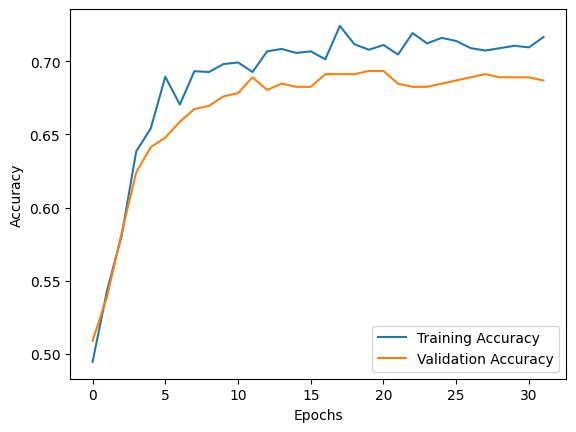

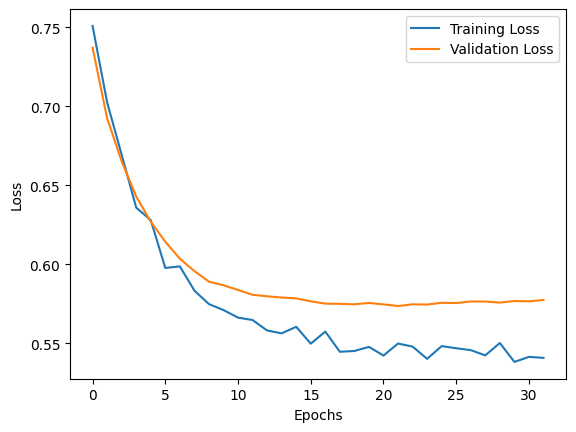

In [93]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Plot training accuracy vs. test accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss vs. validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

model = Sequential([
    Dense(64, activation='relu', input_shape=(26,), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/100


c:\Users\spiri\anaconda3\envs\tf-gpu\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4996 - loss: 1.0464 - val_accuracy: 0.6522 - val_loss: 0.7086 - learning_rate: 0.0010
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5736 - loss: 0.8500 - val_accuracy: 0.6717 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6011 - loss: 0.8141 - val_accuracy: 0.6870 - val_loss: 0.6796 - learning_rate: 0.0010
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6327 - loss: 0.7657 - val_accuracy: 0.6913 - val_loss: 0.6727 - learning_rate: 0.0010
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6495 - loss: 0.7404 - val_accuracy: 0.6935 - val_loss: 0.6671 - learning_rate: 0.0010
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6605 - loss: 0.7221 - val_accuracy: 0.6978 - val_loss: 0.6649 - learning_rate: 0.0010
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6477 - loss: 0.7242 - val_accuracy: 0.693